<a href="https://colab.research.google.com/github/Melo987/-v2/blob/main/%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9CLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install matplotlib==3.0.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import torch
from torch import nn
from d2l import torch as d2l


In [37]:
class Reshape(torch.nn.Module):
  def forward(self,x):
    return x.view(-1,1,28,28)

net = torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.ReLU(),
    nn.MaxPool2d(2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),nn.ReLU(),
    nn.Linear(120,84),nn.ReLU(),
    nn.Linear(84,10)
)

In [38]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [39]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [40]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [41]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.205, train acc 0.924, test acc 0.901
42497.1 examples/sec on cuda:0


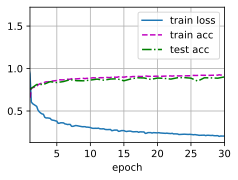

In [49]:
lr, num_epochs = 0.085, 30
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

激活函数换成relu，lr调成0.1，loss 0.335, train acc 0.876, test acc 0.853，稍微有一些过拟合

lr, num_epochs = 0.05, 10，loss 0.372, train acc 0.863, test acc 0.828

0.08，10，loss 0.345, train acc 0.872, test acc 0.864，测试精度更高，过拟合更小

0.09，10，loss 0.344, train acc 0.872, test acc 0.856

0.08，20，loss 0.293, train acc 0.890, test acc 0.873

0.09，20，loss 0.280, train acc 0.894, test acc 0.843过拟合更大了

relu搭配最大池化层
0.1，10，loss 0.299, train acc 0.890, test acc 0.867



0.05，10，loss 0.340, train acc 0.875, test acc 0.857

0.08，10，loss 0.305, train acc 0.887, test acc 0.867

0.085*，10，*loss 0.289, train acc 0.893, test acc 0.871

0.09，10，loss 0.293, train acc 0.892, test acc 0.860，过拟合增加，测试精度降低

0.075，10，loss 0.317, train acc 0.882, test acc 0.858



0.085，20，loss 0.252, train acc 0.905, test acc 0.880

0.085，30，25次左右时出现明显的过拟合，loss 0.205, train acc 0.924, test acc 0.901
